# Knowledge Distillation: Transformer to BiLSTM/CNN for text classification

This project will implement knowledge distillation from a Transformer (tracher) to either a BiLSTM or CNN(student) model for text classification using the DBPedia dataset. We will compare the performance and compression gains between the architectures

Dataset: https://www.kaggle.com/datasets/danofer/dbpedia-classes/data


# Project Plan
1. Data Preparation and Exploration
2. Building the Teacher Model (Transformer)
3. Building Student Models (BiLSTM and CNN)
4. Implementing Knowledge Distillation
5. Training and Evaluation
6. Comparing Results

# 1. Data Preparation and Exploration

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [2]:
# Set the seeds
torch.manual_seed(46)
np.random.seed(46)

In [3]:
# Load dataset
train_df = pd.read_csv("DBPEDIA_train.csv")
val_df = pd.read_csv("DBPEDIA_val.csv")
test_df = pd.read_csv("DBPEDIA_test.csv")

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (240942, 4)
Validation set shape: (36003, 4)
Test set shape: (60794, 4)


In [4]:
# Check class distribution, l1 for simplicity
print("\nClass distribution (l1) in train set")
print(train_df["l1"].value_counts())


Class distribution (l1) in train set
l1
Agent             124798
Place              45877
Species            21472
Work               21013
Event              19106
SportsSeason        5883
UnitOfWork          1761
TopicalConcept       784
Device               248
Name: count, dtype: int64


In [5]:
# Basic text stats
train_df["text_length"] = train_df["text"].apply(len)
print("\nText length statistics:")
print(train_df["text_length"].describe())


Text length statistics:
count    240942.000000
mean        626.702339
std         533.338240
min          50.000000
25%         247.000000
50%         450.000000
75%         831.000000
max        3944.000000
Name: text_length, dtype: float64


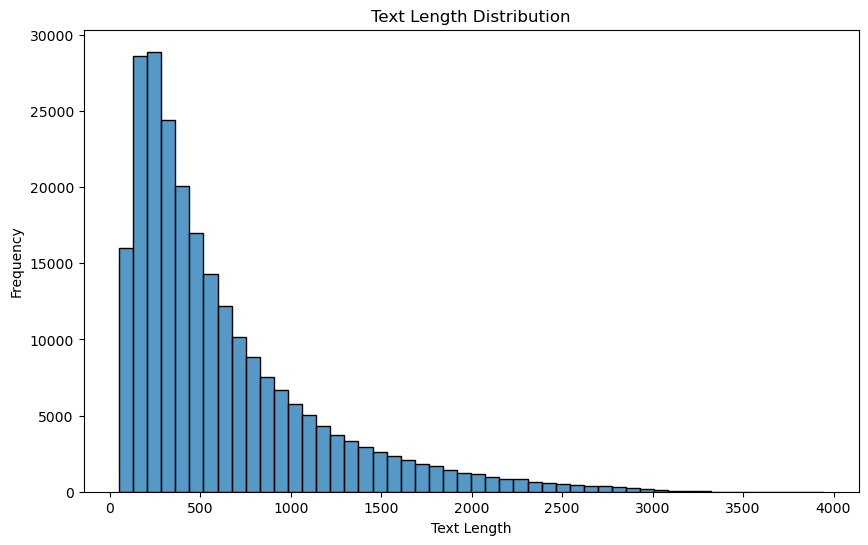

In [6]:
# Visualise text length distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_df["text_length"], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


In [7]:
# Check for missing values
print("\nMissing values in training set:")
print(train_df.isnull().sum())


Missing values in training set:
text           0
l1             0
l2             0
l3             0
text_length    0
dtype: int64


In [8]:
# Display some examples
print("\nSample data:")
train_df.head(3)


Sample data:


,text,l1,l2,l3,text_length
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator,1402
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album,1183
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain,366


# 1.2 Data Preprocessing and Tokenization

Now I will create the preprocessing pipeline and setup tokenizers for both the teacher and student model.

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the NLTK resources
# nltk.download("punkt")
# nltk.download("stopwords")

In [10]:
# Define the preprocessing function
import re

def preprocess_text(text):
    text = text.lower()

    # remove special chars
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", "", text).strip()

    # tokenize
    tokens = word_tokenize(text)

    return " ".join(tokens)


In [11]:
# Apply the preprocessing to all datasets
from sklearn.preprocessing import LabelEncoder

print("Preprocessing text data...")
train_df["processed_text"] = train_df["text"].apply(preprocess_text)
val_df["processed_text"] = val_df["text"].apply(preprocess_text)
test_df["processed_text"] = test_df["text"].apply(preprocess_text)

# Encode target label
label_encoder_l1 = LabelEncoder()
train_df["l1_encoded"] = label_encoder_l1.fit_transform(train_df["l1"])
val_df["l1_encoded"] = label_encoder_l1.transform(val_df["l1"])
test_df["l1_encoded"] = label_encoder_l1.transform(test_df["l1"])

num_classes = len(label_encoder_l1.classes_)
print(f"Number of classes (l1): {num_classes}")
print(f"Classes: {label_encoder_l1.classes_}")

Preprocessing text data...
Number of classes (l1): 9
Classes: ['Agent' 'Device' 'Event' 'Place' 'Species' 'SportsSeason'
 'TopicalConcept' 'UnitOfWork' 'Work']


In [12]:
# Create vocab for the student models
def build_vocab(texts, max_vocab_size=30000):
    word_counts = {}
    for text in texts:
        for word in text.split():
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    
    # Sort words by frequency
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

    # Create word to index mapping
    word_to_idx = {"<PAD>": 0, "<UNK>":1}
    for i, (word, _) in enumerate(sorted_words[:max_vocab_size-2]):
        word_to_idx[word] = i+2
    
    return word_to_idx

In [13]:
# Build vocab from the train set
print("Building vocabulary for student models...")
word_to_idx = build_vocab(train_df["processed_text"])
vocab_size = len(word_to_idx)
print(f"Vocabulary size: {vocab_size}")

Building vocabulary for student models...
Vocabulary size: 30000


In [14]:
# For the transformer I will use the pre trained tokenizer
from transformers import AutoTokenizer, AutoModel

transformer_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
transformer_tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [15]:
## Create Custom Dataset classes
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_to_idx, max_len=128):
        self.texts = texts
        self.labels = labels
        self.word_to_idx = word_to_idx
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx].split()
        # Truncate or pad the sequence
        if len(text) > self.max_len:
            text = text[:self.max_len]
        else:
            text += ["<PAD>"] * (self.max_len - len(text))
        
        # Convert words to indicies
        indices = [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in text]

        return {
            "input_ids": torch.tensor(indices),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [16]:
class TransformerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens = True,
            max_length = self.max_len,
            padding = "max_length",
            truncation = True,
            return_attention_mask = True,
            return_tensors = "pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }
    

In [17]:
# Creating datasets
MAX_LEN = 128
BATCH_SIZE = 32

# For students
train_dataset = TextDataset(
    train_df["processed_text"].tolist(),
    train_df["l1_encoded"].tolist(),
    word_to_idx,
    max_len=MAX_LEN
)

val_dataset = TextDataset(
    val_df["processed_text"].tolist(),
    val_df["l1_encoded"].tolist(),
    word_to_idx,
    max_len=MAX_LEN
)

test_dataset = TextDataset(
    test_df["processed_text"].tolist(),
    test_df["l1_encoded"].tolist(),
    word_to_idx,
    max_len=MAX_LEN
)

# For transformer model
train_transformer_dataset = TransformerDataset(
    train_df["processed_text"].tolist(),
    train_df["l1_encoded"].tolist(),
    transformer_tokenizer,
    max_len=MAX_LEN
)

val_transformer_dataset = TransformerDataset(
    val_df["processed_text"].tolist(),
    val_df["l1_encoded"].tolist(),
    transformer_tokenizer,
    max_len=MAX_LEN
)

test_transformer_dataset = TransformerDataset(
    test_df["processed_text"].tolist(),
    test_df["l1_encoded"].tolist(),
    transformer_tokenizer,
    max_len=MAX_LEN
)

In [18]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

train_transformer_loader = DataLoader(train_transformer_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_transformer_loader = DataLoader(val_transformer_dataset, batch_size=BATCH_SIZE)
test_transformer_loader = DataLoader(test_transformer_dataset, batch_size=BATCH_SIZE)

# Check a batch
sample_batch = next(iter(train_loader))
print(f"Sample batch shape for student models (input_ids): {sample_batch["input_ids"].shape}")
print(f"Sample batch shape for student models (labels): {sample_batch["labels"].shape}")

sample_transformer_batch = next(iter(train_transformer_loader))
print(f"Sample batch shape for transformer (input_id): {sample_transformer_batch["input_ids"].shape}")
print(f"Sample batch shape for transformer (attention_mask): {sample_transformer_batch["attention_mask"].shape}")
print(f"Sample batch shape for transformer (labels): {sample_transformer_batch["labels"].shape}")

Sample batch shape for student models (input_ids): torch.Size([32, 128])
Sample batch shape for student models (labels): torch.Size([32])
Sample batch shape for transformer (input_id): torch.Size([32, 128])
Sample batch shape for transformer (attention_mask): torch.Size([32, 128])
Sample batch shape for transformer (labels): torch.Size([32])


# 2. Building the Transformer (Teacher)

In [19]:
import torch.nn as nn
import torch.optim as optim


class TransformerClassifier(nn.Module):
    def __init__(self, pretrained_model_name="distilbert-base-uncased", num_classes=9):
        super(TransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [20]:
# Function to train the teacher model
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

def train_teacher_model(model, train_loader, val_loader, num_epochs=5, learning_rate=5e-5, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # List to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    best_val_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch in train_progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)

            # Compute loss
            loss = criterion(logits, labels)
            train_loss += loss.item()

            # Backward pass and optimisation
            loss.backward()
            optimizer.step()

            # Update progress bar
            train_progress_bar.set_postfix({"loss": loss.item()})
        
        # Calculate average training loss
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch in val_progress_bar:
                inputs_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                # Forward pass
                logits = model(inputs_ids, attention_mask)

                # Compute loss
                loss = criterion(logits, labels)
                val_loss += loss.item()

                # Get predictions
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

                # Update the progress bar
                val_progress_bar.set_postfix({"loss": loss.item()})
        
        # Calculate avg validation loss and accuracy
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_teacher_model.pth")
            print(f"New best model saved with validation accuracy: {val_accuracy:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel('Epoch')
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curves")

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")

    plt.tight_layout()
    plt.savefig("teacher_training_curves.png")
    plt.show()

    return model

In [21]:
# Function to evaluate the teacher model
def evaluate_teacher_model(model, test_loader, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating")
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask)

            # Get predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_logits.append(logits.cpu())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Generate classificaiton report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder_l1.classes_))

    # Combine all logits
    all_logits = torch.cat(all_logits, dim=0)

    return all_preds, all_labels, all_logits, accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")            

using device: cuda


In [24]:
# Define the model
teacher_model = TransformerClassifier(num_classes=num_classes)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 1/3 [Val]: 100%|██████████| 1126/1126 [01:00<00:00, 18.76it/s, loss=1.61] 


Epoch 1/3:
Training Loss: 1.3369
Validation Loss: 1.3178
Validation Accuracy: 0.5609
New best model saved with validation accuracy: 0.5609


Epoch 2/3 [Val]: 100%|██████████| 1126/1126 [01:01<00:00, 18.27it/s, loss=1.59] 


Epoch 2/3:
Training Loss: 1.3152
Validation Loss: 1.3092
Validation Accuracy: 0.5625
New best model saved with validation accuracy: 0.5625


Epoch 3/3 [Val]: 100%|██████████| 1126/1126 [00:59<00:00, 18.82it/s, loss=1.64] 


Epoch 3/3:
Training Loss: 1.3094
Validation Loss: 1.3141
Validation Accuracy: 0.5620


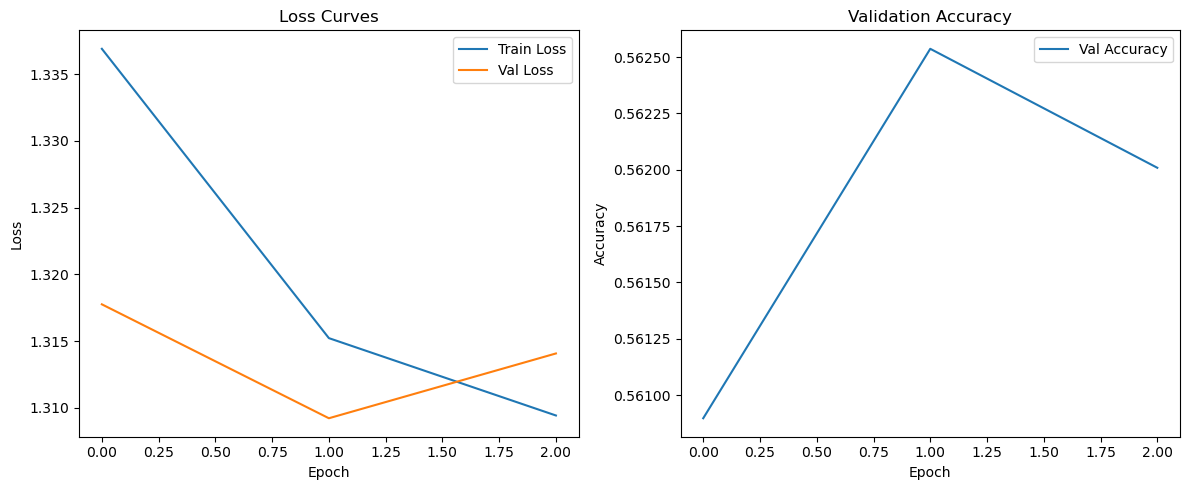

Evaluating: 100%|██████████| 1900/1900 [01:40<00:00, 18.98it/s]

Test Accuracy: 0.5608

Classification Report:
                precision    recall  f1-score   support

         Agent       0.54      1.00      0.70     31495
        Device       0.00      0.00      0.00        62
         Event       0.74      0.04      0.07      4820
         Place       0.96      0.09      0.17     11574
       Species       0.98      0.14      0.25      5418
  SportsSeason       0.94      0.06      0.11      1483
TopicalConcept       0.67      0.02      0.04       198
    UnitOfWork       0.89      0.11      0.19       444
          Work       0.86      0.11      0.19      5300

      accuracy                           0.56     60794
     macro avg       0.73      0.17      0.19     60794
  weighted avg       0.72      0.56      0.44     60794

Teacher model accuracy: 0.5608



c:\Users\bharg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bharg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\bharg\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:

teacher_model = train_teacher_model(
    teacher_model,
    train_transformer_loader,
    val_transformer_loader,
    num_epochs=3,
    learning_rate=3e-4,
    device=device
)

# Evaluate the teacher model
teacher_preds, teacher_labels, teacher_logits, teacher_accuracy = evaluate_teacher_model(
    teacher_model,
    test_transformer_loader,
    device=device
)
print(f"Teacher model accuracy: {teacher_accuracy:.4f}")

In [23]:
teacher_probs = F.softmax(teacher_logits, dim=1)
torch.save(teacher_probs, "teacher_probs.pt")

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_probs = torch.load("teacher_probs.pt", map_location=device)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Teacher model has {count_parameters(teacher_model):,} parameters")

Teacher model has 66,369,801 parameters


In [28]:
# Define the BiLSTM model
class BiLSTMClissifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=128, output_dim=9, n_layers=2, dropout=0.5):
        super(BiLSTMClissifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # BiLSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedding = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedding)

        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)

        return logits

In [29]:
# CNN Model
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, n_filters=100,
                 filter_sizes=[3, 4, 5], output_dim=9, dropout=0.5):
        super(CNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters,
                      kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        logits = self.fc(cat)

        return logits

In [30]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [31]:
# Initialize student models
bilstm_model = BiLSTMClissifier(vocab_size=vocab_size, output_dim=num_classes)
cnn_model = CNNClassifier(vocab_size=vocab_size, output_dim=num_classes)

In [33]:
# Print model sizes
print(f'BiLSTM model has {count_parameters(bilstm_model):,} parameters')
print(f'CNN model has {count_parameters(cnn_model):,} parameters')
print(f'Teacher model has {count_parameters(teacher_model):,} parameters')

BiLSTM model has 3,633,097 parameters
CNN model has 3,123,009 parameters
Teacher model has 66,369,801 parameters


In [34]:
# BiLSTM size reduction compared to teacher
bilstm_reduction = (1-count_parameters(bilstm_model) / count_parameters(teacher_model)) * 100
print(f"BiLSTM model is {bilstm_reduction:.2f}% smaller than the teacher model")

BiLSTM model is 94.53% smaller than the teacher model


In [35]:
# CNN size reduction compared to teacher
cnn_reduction = (1-count_parameters(cnn_model) / count_parameters(teacher_model)) * 100
print(f"CNN model is {cnn_reduction:.2f}% smaller than the teacher model")

CNN model is 95.29% smaller than the teacher model


# Implement Knowledge Distillation

In [36]:
def distillation_loss(student_logits, teacher_probs, labels, temperature=2.0, alpha=0.5):
    """Compute the knowledge distillation loss"""
    student_logits_soft = student_logits / temperature

    soft_targets_loss = F.kl_div(
        F.log_softmax(student_logits_soft, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (temperature ** 2)

    # Compute hard targets loss
    hard_targets_loss = F.cross_entropy(student_logits, labels)
    loss = alpha * soft_targets_loss + (1 - alpha) * hard_targets_loss

    return loss

In [ ]:
def train_student_model(
        model, 
        train_loader,
        val_loader,
        teacher_probs_path = "teacher_probs.pt",
        num_epochs = 10,
        learning_rate = 0.001,
        temperature = 2.0,
        alpha = 0.5,
        device = "cuda" if torch.cuda.is_available() else "cpu"
):
    model = model.to(device)
    teacher_probs = torch.load(teacher_probs_path)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5, verbose=True
    )

    # List to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # train loop
    best_val_accuracy = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, batch in enumerate(train_progress_bar):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            